# Validation using AML31 case with Orthogonal Validation

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport manual_review_classifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from manual_review_classifier.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot, make_model_output_plot
from manual_review_classifier.Analysis import determine_feature_importance, print_accuracy_and_classification_report, predict_classes, get_somatic_error_type, calculate_kappa

sns.set_style("white")
sns.set_context('talk')

Using TensorFlow backend.


In [4]:
# Pull in training data
training_data = pd.read_pickle('../data/training_data.pkl')
# Remove AML31 case
training_data = training_data[~training_data.index.str.contains('H_KA-452198')]

In [5]:
# Show the calls associate with training data
training_data.groupby('call').size()

call
a    10643
f     8854
g     3122
s    18381
dtype: int64

In [8]:
# Re-label the germline calls as failed calls
three_class = training_data.replace('g','f')

# Condense disease types (solid = 0, liquid = 1)
s_v_b = three_class
s_v_b['solid_tumor'] = s_v_b[['disease_GST', 'disease_MPNST', 'disease_SCLC',
                              'disease_breast', 'disease_colorectal', 
                              'disease_glioblastoma', 'disease_melanoma']].apply(any, axis=1).astype(int)
s_v_b.drop(['disease_AML', 'disease_GST', 'disease_MPNST', 'disease_SCLC',
       'disease_breast', 'disease_colorectal', 'disease_glioblastoma',
       'disease_lymphoma', 'disease_melanoma'], axis=1, inplace=True)

# Show the calls associate with training data
s_v_b.groupby('call').size()


call
a    10643
f    11976
s    18381
dtype: int64

In [10]:
# Get labels for training data
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = s_v_b.sort_index(axis=1).drop(['call', 'reviewer_1',
                'reviewer_2', 'reviewer_3', 
                'reviewer_4'], axis=1).astype(float).values

In [58]:
# Pull in AML31 data
aml31 = pd.read_pickle('../data/aml31/train.pkl')

# Label disease type as liquid tumor (solid tumors are 0)
aml31['solid_tomor']=1

# Drop disease type and reviewer
aml31_X = aml31.sort_index(axis=1).drop(['disease_AML', 'reviewer_None'], axis=1).astype(float).values

In [59]:
# Test shape of AML31 data
aml31.shape

(192241, 61)

In [60]:
# Pull in results from orthogonal sequencing 
platinum = pd.read_csv('../data/aml31/Supplemental_Dataset_3-PlatinumSnvList.tsv', sep='\t')
platinum.rename(columns={'chromosome_name':'chr',  'reference':'ref', 'variant':'var'}, inplace=True)

# Deep Learning Model

In [61]:
# Create function to define baseline model
def test_model():
    # create model
    model = Sequential()
    model.add(Dense(59, input_dim=59, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [62]:
# Set deep learning model parameters
test_estimator = KerasClassifier(build_fn=test_model, epochs=700, batch_size=2000, verbose=0)

# Fit model using training data
test_estimator.fit(X, Y)

# Employ trained model to predict AML31 variants
predictions = test_estimator.predict_proba(aml31_X)

In [63]:
# Add headers to predictions dataframe
predictions = pd.DataFrame(predictions, columns=['amb', 'fail', 'somatic'])

# Format predictions output
predictions.index = aml31.index
predictions['individual_name'] = predictions.index.str.extract('(.*)~', expand=False)
predictions['chr'] = predictions.index.str.extract('~(.*):', expand=False)
predictions['start'] = predictions.index.str.extract(':(.*)-\d+[A-z-]+>', expand=False)
predictions['stop'] = predictions.index.str.extract('\d+-(\d*)[A-z-]+>', expand=False)
predictions['ref'] = predictions.index.str.extract('-\d+([A-z-]+)>', expand=False)
predictions['var'] = predictions.index.str.extract('>([A-z-]+)', expand=False)

# Pull prediction values
predictions['prediction'] = test_estimator.predict(aml31_X)

# Format values for start and stop
predictions['start'] = predictions.start.astype(int)
predictions['stop'] = predictions.stop.astype(int)

In [78]:
# Annotate the predictions file with coordinates from platinum list
m = pd.merge(predictions, platinum, how='left', on=['chr', 'start', 'stop', 'ref', 'var'])

In [79]:
# If gene_name NA replace with 0
m.gene_name.fillna(0, inplace=True)

In [71]:
# Define iteration by row function
def row_is_null(row):
    if row==0:
        return 0
    else:
        return 1

In [81]:
# Apply row function to merged dataframe
m['validated'] = m['gene_name'].apply(row_is_null)

In [82]:
# Calculate false positive rate and true positive rate
dl_fpr, dl_tpr, _ = metrics.roc_curve(m.validated, m.somatic)
dl_auc = metrics.auc(dl_fpr, dl_tpr)


[  0.00000000e+00   0.00000000e+00   5.23820749e-06 ...,   9.87004007e-01
   9.87004007e-01   1.00000000e+00]


In [20]:
# Determine AUC for deep learning model
dl_auc

0.96306270738165367

# Random Forest Model

In [84]:
# Get Labels for random forest model
Y_rf = three_class.call.values

In [86]:
# Set random forest parameters
estimator = RandomForestClassifier(n_estimators=1000, max_features=8, 
                                   n_jobs=-1, oob_score=True)

# Fit model using training data
estimator.fit(X, Y_rf)

# Employ trained model to predict AML31 variants
predictions_rf = estimator.predict_proba(aml31_X)

In [87]:
# Add headers to predictions dataframe
predictions_rf = pd.DataFrame(predictions_rf, columns=['amb', 'fail', 'somatic'])

# Format predictions output
predictions_rf.index = aml31.index
predictions_rf['individual_name'] = predictions_rf.index.str.extract('(.*)~', expand=False)
predictions_rf['chr'] = predictions_rf.index.str.extract('~(.*):', expand=False)
predictions_rf['start'] = predictions_rf.index.str.extract(':(.*)-\d+[A-z-]+>', expand=False)
predictions_rf['stop'] = predictions_rf.index.str.extract('\d+-(\d*)[A-z-]+>', expand=False)
predictions_rf['ref'] = predictions_rf.index.str.extract('-\d+([A-z-]+)>', expand=False)
predictions_rf['var'] = predictions_rf.index.str.extract('>([A-z-]+)', expand=False)

# Pull prediction values
predictions_rf['prediction'] = estimator.predict(aml31_X)

# Format values for start and stop
predictions_rf['start'] = predictions_rf.start.astype(int)
predictions_rf['stop'] = predictions_rf.stop.astype(int)


In [88]:
# Annotate the predictions file with coordinates from platinum list
m_rf = pd.merge(predictions_rf, platinum, how='left', on=['chr', 'start', 'stop','ref', 'var'])

In [89]:
# If gene_name NA replace with 0
m_rf.gene_name.fillna(0, inplace=True)

In [90]:
# Apply row function to merged dataframe
m_rf['validated'] = m_rf['gene_name'].apply(row_is_null)

In [91]:
# Calculate false positive rate and true positive rate
rf_fpr, rf_tpr, _ = metrics.roc_curve(m_rf.validated, m_rf.somatic)
rf_auc = metrics.auc(rf_fpr, rf_tpr)

In [92]:
# Determine AUC for random forest model
rf_auc

0.96144573820850487

# Plot AUC Curves for DL and RF 

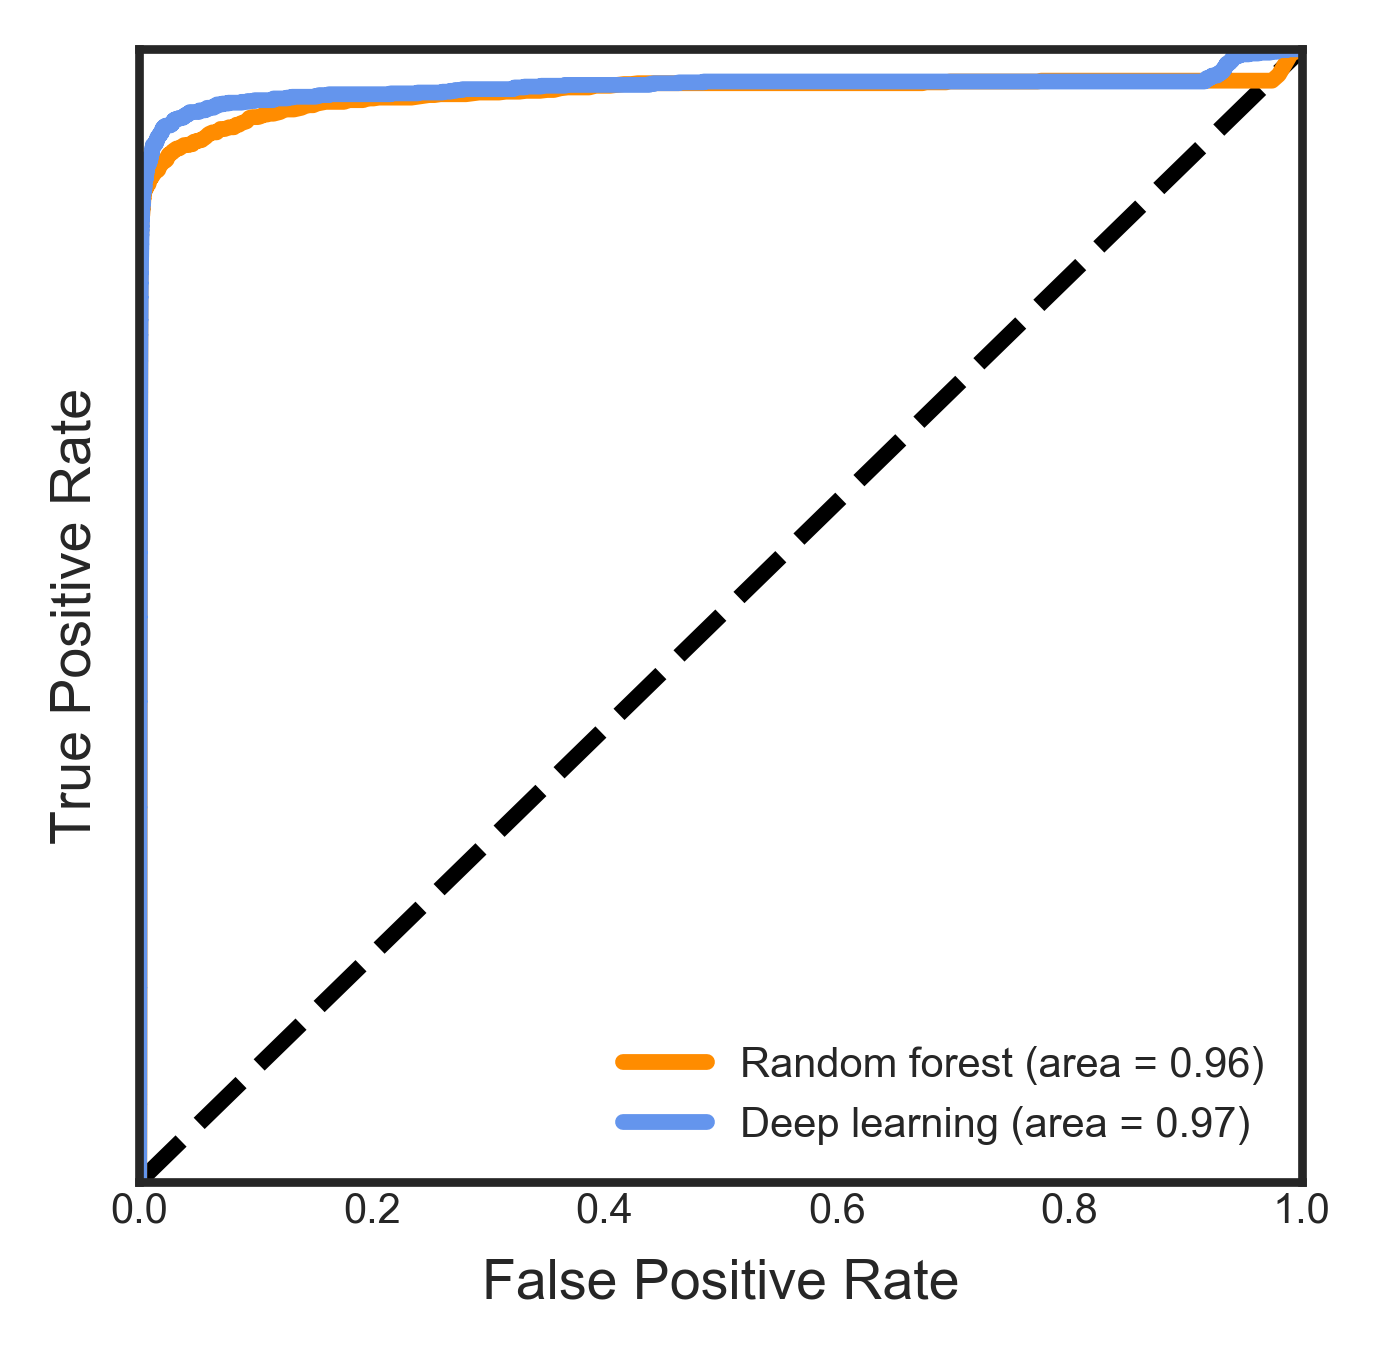

In [93]:
# Plot accuracy for random forest AUC and deep learning AUC

fig, (ax1) = plt.subplots(1, figsize=(3,3),dpi=500)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.plot(rf_fpr, rf_tpr, color='darkorange', label='Random forest'
             ' (area = {0:0.2f})'.format(rf_auc))
ax1.plot(dl_fpr, dl_tpr, color='cornflowerblue', label='Deep learning'
             ' (area = {0:0.2f})'.format(dl_auc))
ax1.set_xlabel('False Positive Rate',fontsize=8)
ax1.set_ylabel('True Positive Rate',fontsize=8)
ax1.legend(fontsize=6)
ax1.tick_params(labelsize=6, pad=1.5)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
yticklabels = ax1.get_yticklabels()
yticklabels[0] = ''
ax1.set_yticklabels(yticklabels)
fig.savefig('../figures/validation_performance.png')
fig.savefig('../figures/validation_performance.pdf')
